<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import io
import pandas as pd
import xarray as xa


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torch.autograd import Variable
from tqdm.notebook import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [2]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/gVrTFgSJ1rWl1IN/download')
test_x, test_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/JR0WXbrzzTAmwEB/download')


print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

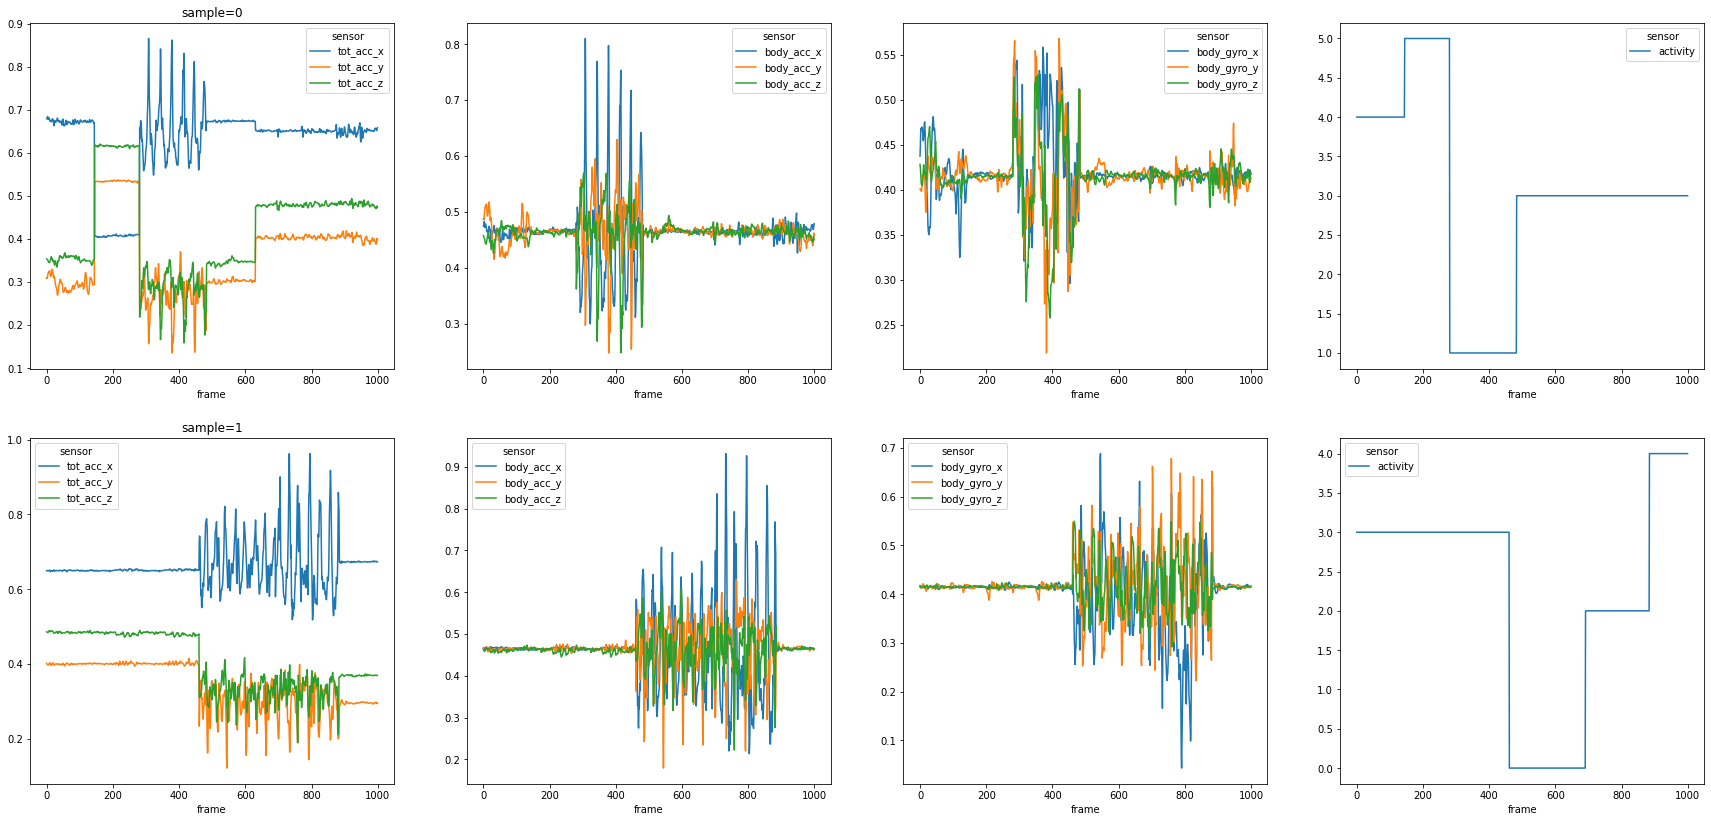

In [3]:
def to_df(x, y):
    """
    Converts training/testing input features and corresponding labels into
    a Pandas Dataframe format
    
    Inputs:
    x: Input features (train or test) in numpy array format
    y: Targets/labels (train or test) in numpy array format
    
    Output:
    dataset_df: Train or test data, structered as a table with column names
    """
    
    numpy_data = np.concatenate([x,y], axis=2)
    
    dataset_df = xa.DataArray(numpy_data, 
                                     dims = ['N', 'frame', 'sensor'],
                                     name='training_data')\
                                        .to_dataframe()\
                                        .unstack('sensor')['training_data']\
                                        .reset_index()

    column_names = ['tot_acc_x', 'tot_acc_y', 'tot_acc_z', 'body_acc_x', 'body_acc_y',
       'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'activity']
    
    dataset_df = dataset_df.rename(columns = dict(zip(list(dataset_df.columns[2:]), 
                                                      column_names)))\
                                         .astype({'activity':int})

    return dataset_df



def plot_training_samples(N, dataset_df):
    """
    Plots samples in test/train dataset
    
    Inputs 
    N: Number of samples that will be visualised. 
    dataset_df: Train or test data, structered as a table with column names. 
                This tabular structured data can be obtained with `to_df` function.
    """
    
    f, axes = plt.subplots(N, 4, figsize=(30, N*7))
    axes = iter(axes)

    for pid, df_pid in list(dataset_df.groupby('N'))[:N]:

        ax_tot_acc, ax_body_acc, ax_body_gyro, ax_activity = tuple(next(axes))

        df_pid.plot(x = 'frame', y=['tot_acc_x','tot_acc_y', 'tot_acc_z'], title=f'sample={pid}', ax=ax_tot_acc)
        df_pid.plot(x = 'frame', y=['body_acc_x','body_acc_y', 'body_acc_z'], ax=ax_body_acc)
        df_pid.plot(x = 'frame', y=['body_gyro_x','body_gyro_y', 'body_gyro_z'], ax=ax_body_gyro)
        df_pid.plot(x = 'frame', y=['activity'], ax=ax_activity) 
        
    
    

training_data_df = to_df(train_x, train_y)

plot_training_samples(2, training_data_df);

### Data Preprocessing

First we need to convert the data type of the given data, and then pack the x and label into `dataset`.

In [4]:
tr_x = torch.from_numpy(train_x).type(torch.FloatTensor) 
tr_y = torch.from_numpy(train_y).long()
tr_y = torch.reshape(tr_y, (tr_y.size(0), tr_y.size(1)))

va_x = torch.from_numpy(test_x).type(torch.FloatTensor)
va_y = torch.from_numpy(test_y).long()
va_y = torch.reshape(va_y, (va_y.size(0), va_y.size(1)))

print(tr_x.type(), tr_x.size(), tr_y.type(), tr_y.size())
print(va_x.type(), va_x.size(), va_y.type(), va_y.size())


tr_dataset = TensorDataset(tr_x, tr_y)
va_dataset = TensorDataset(va_x, va_y)

torch.FloatTensor torch.Size([10000, 1000, 9]) torch.LongTensor torch.Size([10000, 1000])
torch.FloatTensor torch.Size([2000, 1000, 9]) torch.LongTensor torch.Size([2000, 1000])


### Build a CNN-LSTM-based model

We pass the CNN-encoded data into LSTM layer(s), then apply the same MLP to every LSTM output step.

In [15]:
class CNNLSTMModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_layer, n_output, device=torch.device('cpu'), batch_first=True):
        super(CNNLSTMModel, self).__init__()

        self.n_hidden = n_hidden
        self.n_layer = n_layer
        
        self.conv = nn.Conv1d(n_input, n_hidden, 3, stride=1, padding=1)
                
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layer)
        self.mlp = nn.Sequential(
            nn.Linear(n_hidden, 32),
            nn.ReLU(),
            nn.Linear(32, n_output)
        )
        self.device = device
        
    

    def forward(self, x):
        # x: batch_size * time * feature, 32*1000*9

        x = torch.transpose(x, 1, 2)
        conv_out = self.conv(x)

        n_time = conv_out.size(2)
        conv_out = torch.transpose(conv_out, 1, 2)
        
        # init h0 and c0 to 0
        h0 = Variable(torch.zeros(self.n_layer, n_time, self.n_hidden)).to(self.device)
        c0 = Variable(torch.zeros(self.n_layer, n_time, self.n_hidden)).to(self.device)

        lstm_out, (hn, cn) = self.rnn(conv_out, (h0, c0))
        # pass every step into mlp
        prob_space = self.mlp(lstm_out[:, :, :])

        return prob_space

### Build custom loss function

`F.cross_entropy` only supports 1D labels, so we need to build a new loss function based on this to adapt to 2D labels (`batch_size`*`time_step`) in this case

In [6]:
class CrossEntropyLoss2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.single_loss_func = F.cross_entropy
        
    def forward(self, est, tar):
        num = est.size(0)
        loss = torch.zeros(num)
        for i in range(num):
            loss[i] = self.single_loss_func(est[i], tar[i])
        return torch.mean(loss)


### Define `Trainer()` class

In [7]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 tr_DataLoader: torch.utils.data.Dataset,
                 va_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.tr_DataLoader = tr_DataLoader
        self.va_DataLoader = va_DataLoader
        self.device = device
        self.epochs = epochs

        self.tr_loss_log = []
        self.va_loss_log = []
        self.va_accu_log = []

        self.best_va_accu = -0.01
        # self.best_va_loss = float('inf')
        self.best_parameter = {}

    
    def train(self):
        '''
        behavior within one epoch
        '''
        self.model.train()  # enter train mode
        train_loss = []

        for i, (x, tar) in enumerate(tqdm(self.tr_DataLoader)):
            
            
            x, tar = x.to(self.device), tar.to(self.device)  # send to device
            
            out = self.model(x)  # one forward pass

            loss = self.criterion(out, tar)  # calculate loss

            self.optimizer.zero_grad()  # zerograd the parameters
                
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            loss_value = loss.item()
            train_loss.append(loss_value)

            print(f'\r tr_loss: ', np.mean(train_loss), end=" ")
        
        return np.mean(train_loss)


    def valid(self, print_info=True):
        '''
        behavior of one validation step
        '''
        self.model.eval()  # enter evaluation mode
        valid_loss = []
        valid_accu = []
        est_holder = []
        tar = torch.empty((0)).to(device)

        with torch.no_grad():
            for i, (x, this_tar) in enumerate(tqdm(self.va_DataLoader)):
                x, this_tar = x.to(self.device), this_tar.to(self.device)  # send to device

                tar = torch.cat((tar, this_tar), 0)
            
                out = self.model(x)  # one forward pass
                loss = self.criterion(out, this_tar)  # calculate loss

                this_est = torch.argmax(out, axis=-1)  # estimation
                est_holder.append(this_est)

                loss_value = loss.item()
                valid_loss.append(loss_value)
        
        est = torch.empty((0, est_holder[0].size(1))).to(self.device)
        for this_est in est_holder:
            est = torch.cat((est, this_est), 0)
        
        torch.cuda.empty_cache()
        va_loss = np.mean(valid_loss)
        va_accu = float(torch.eq(est, tar).sum()/(est.size(0)*est.size(1)))
        if print_info:
            print(f"\r va_loss: ", va_loss, end=" ")
        return va_loss, va_accu, est, tar


    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            tr_loss = self.train()
            va_loss, va_accu, _, _ = self.valid()
            
            # update
            if va_accu > self.best_va_accu:
                self.best_va_accu = va_accu
                self.best_parameter = self.model.state_dict()
            self.tr_loss_log.append(tr_loss)
            self.va_loss_log.append(va_loss)
            self.va_accu_log.append(va_accu)
            
            # print result every epoch
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'TR-LOSS: {tr_loss:.4f}',end=' ')
            print(f'VA-LOSS: {va_loss:.4f}',end=' ')
            print(f'VA-ACCU: {va_accu:.4f}',end=' ')
            print(f'BEST-VA-ACCU: {self.best_va_accu:.4f}',end='\n')
            


### Train model

We first define the hyper parameters of models and training.

In [8]:
N_FEATURE = 9
N_HIDDEN = 64
N_LAYER = 2
OUTPUT_SIZE = 6

EPOCH = 200
BATCH_SIZE = 64

In [9]:
# device
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

# model
model = CNNLSTMModel(n_input=N_FEATURE, n_hidden=N_HIDDEN, n_layer=N_LAYER, n_output=OUTPUT_SIZE, device=device)
model = model.to(device)

# criterion
criterion = CrossEntropyLoss2D()
criterion = criterion.to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

# loader
tr_dataloader = DataLoader(tr_dataset, shuffle=True, batch_size=BATCH_SIZE)
va_dataloader = DataLoader(va_dataset, shuffle=True, batch_size=BATCH_SIZE)

cuda


In [10]:
# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    tr_DataLoader=tr_dataloader,
    va_DataLoader=va_dataloader,
    epochs=EPOCH
)

# start training
trainer.run_trainer()

 tr_loss:  1.7735090498711652 




 va_loss:  1.7697421051561832 EPOCH: 001/200 TR-LOSS: 1.7735 VA-LOSS: 1.7697 VA-ACCU: 0.2038 BEST-VA-ACCU: 0.2038


 tr_loss:  1.7628852979392762 




 va_loss:  1.6819140128791332 EPOCH: 002/200 TR-LOSS: 1.7629 VA-LOSS: 1.6819 VA-ACCU: 0.2585 BEST-VA-ACCU: 0.2585


 tr_loss:  1.3368474784170745 




 va_loss:  1.3184248767793179 EPOCH: 003/200 TR-LOSS: 1.3368 VA-LOSS: 1.3184 VA-ACCU: 0.4232 BEST-VA-ACCU: 0.4232


 tr_loss:  1.0669055417844444 




 va_loss:  0.9257425107061863 EPOCH: 004/200 TR-LOSS: 1.0669 VA-LOSS: 0.9257 VA-ACCU: 0.6204 BEST-VA-ACCU: 0.6204


 tr_loss:  0.9088625080266576 




 va_loss:  0.8215681333094835 EPOCH: 005/200 TR-LOSS: 0.9089 VA-LOSS: 0.8216 VA-ACCU: 0.6620 BEST-VA-ACCU: 0.6620


 tr_loss:  0.8802273884700362 




 va_loss:  0.8753782138228416 EPOCH: 006/200 TR-LOSS: 0.8802 VA-LOSS: 0.8754 VA-ACCU: 0.6405 BEST-VA-ACCU: 0.6620


 tr_loss:  0.829218885321526 




 va_loss:  0.7739803623408079 EPOCH: 007/200 TR-LOSS: 0.8292 VA-LOSS: 0.7740 VA-ACCU: 0.6752 BEST-VA-ACCU: 0.6752


 tr_loss:  0.8091378781446226 




 va_loss:  0.8303658440709114 EPOCH: 008/200 TR-LOSS: 0.8091 VA-LOSS: 0.8304 VA-ACCU: 0.6597 BEST-VA-ACCU: 0.6752


 tr_loss:  0.7790283101379492 




 va_loss:  0.7989542279392481 EPOCH: 009/200 TR-LOSS: 0.7790 VA-LOSS: 0.7990 VA-ACCU: 0.6767 BEST-VA-ACCU: 0.6767


 tr_loss:  0.7684425123178276 




 va_loss:  0.7528882715851068 EPOCH: 010/200 TR-LOSS: 0.7684 VA-LOSS: 0.7529 VA-ACCU: 0.6777 BEST-VA-ACCU: 0.6777


 tr_loss:  0.7515359923338435 




 va_loss:  0.7564996685832739 EPOCH: 011/200 TR-LOSS: 0.7515 VA-LOSS: 0.7565 VA-ACCU: 0.6791 BEST-VA-ACCU: 0.6791


 tr_loss:  0.7526488531926635 




 va_loss:  0.7509884014725685 EPOCH: 012/200 TR-LOSS: 0.7526 VA-LOSS: 0.7510 VA-ACCU: 0.6847 BEST-VA-ACCU: 0.6847


 tr_loss:  0.7348751478893741 




 va_loss:  0.7047747671604156 EPOCH: 013/200 TR-LOSS: 0.7349 VA-LOSS: 0.7048 VA-ACCU: 0.7005 BEST-VA-ACCU: 0.7005


 tr_loss:  0.7324121214781597 




 va_loss:  0.7351161744445562 EPOCH: 014/200 TR-LOSS: 0.7324 VA-LOSS: 0.7351 VA-ACCU: 0.6877 BEST-VA-ACCU: 0.7005


 tr_loss:  0.7399861922689305 




 va_loss:  0.7654892653226852 EPOCH: 015/200 TR-LOSS: 0.7400 VA-LOSS: 0.7655 VA-ACCU: 0.6746 BEST-VA-ACCU: 0.7005


 tr_loss:  0.738307500341136 




 va_loss:  0.7038942184299231 EPOCH: 016/200 TR-LOSS: 0.7383 VA-LOSS: 0.7039 VA-ACCU: 0.7001 BEST-VA-ACCU: 0.7005


 tr_loss:  0.7301571703260872 




 va_loss:  0.6882771532982588 EPOCH: 017/200 TR-LOSS: 0.7302 VA-LOSS: 0.6883 VA-ACCU: 0.7079 BEST-VA-ACCU: 0.7079


 tr_loss:  0.7398783215291941 




 va_loss:  0.6877834871411324 EPOCH: 018/200 TR-LOSS: 0.7399 VA-LOSS: 0.6878 VA-ACCU: 0.7053 BEST-VA-ACCU: 0.7079


 tr_loss:  0.7155337777866679 




 va_loss:  0.6887551434338093 EPOCH: 019/200 TR-LOSS: 0.7155 VA-LOSS: 0.6888 VA-ACCU: 0.7086 BEST-VA-ACCU: 0.7086


 tr_loss:  0.709156076999227 




 va_loss:  0.670413551852107 EPOCH: 020/200 TR-LOSS: 0.7092 VA-LOSS: 0.6704 VA-ACCU: 0.7132 BEST-VA-ACCU: 0.7132


 tr_loss:  0.6775270947225535 




 va_loss:  0.6150657450780272 EPOCH: 021/200 TR-LOSS: 0.6775 VA-LOSS: 0.6151 VA-ACCU: 0.7398 BEST-VA-ACCU: 0.7398


 tr_loss:  0.6137510708942535 




 va_loss:  0.5999930910766125 EPOCH: 022/200 TR-LOSS: 0.6138 VA-LOSS: 0.6000 VA-ACCU: 0.7433 BEST-VA-ACCU: 0.7433


 tr_loss:  0.5497740552683544 




 va_loss:  0.49493983294814825 EPOCH: 023/200 TR-LOSS: 0.5498 VA-LOSS: 0.4949 VA-ACCU: 0.7910 BEST-VA-ACCU: 0.7910


 tr_loss:  0.5470172933712127 




 va_loss:  0.4831477599218488 EPOCH: 024/200 TR-LOSS: 0.5470 VA-LOSS: 0.4831 VA-ACCU: 0.7944 BEST-VA-ACCU: 0.7944


 tr_loss:  0.48414522371474344 




 va_loss:  0.5231964066624641 EPOCH: 025/200 TR-LOSS: 0.4841 VA-LOSS: 0.5232 VA-ACCU: 0.7956 BEST-VA-ACCU: 0.7956


 tr_loss:  0.4727047368599351 




 va_loss:  0.46306990925222635 EPOCH: 026/200 TR-LOSS: 0.4727 VA-LOSS: 0.4631 VA-ACCU: 0.8059 BEST-VA-ACCU: 0.8059


 tr_loss:  0.4623910555034686 




 va_loss:  0.459102276712656 EPOCH: 027/200 TR-LOSS: 0.4624 VA-LOSS: 0.4591 VA-ACCU: 0.8065 BEST-VA-ACCU: 0.8065


 tr_loss:  0.46500051154452526 




 va_loss:  0.44379329215735197 EPOCH: 028/200 TR-LOSS: 0.4650 VA-LOSS: 0.4438 VA-ACCU: 0.8145 BEST-VA-ACCU: 0.8145


 tr_loss:  0.44747550111667367 




 va_loss:  0.4673849157989025 EPOCH: 029/200 TR-LOSS: 0.4475 VA-LOSS: 0.4674 VA-ACCU: 0.7967 BEST-VA-ACCU: 0.8145


 tr_loss:  0.43626586608825974 




 va_loss:  0.408917922526598 EPOCH: 030/200 TR-LOSS: 0.4363 VA-LOSS: 0.4089 VA-ACCU: 0.8243 BEST-VA-ACCU: 0.8243


 tr_loss:  0.4422716771721081 




 va_loss:  0.441374191083014 EPOCH: 031/200 TR-LOSS: 0.4423 VA-LOSS: 0.4414 VA-ACCU: 0.8164 BEST-VA-ACCU: 0.8243


 tr_loss:  0.4486025410472967 




 va_loss:  0.5196593515574932 EPOCH: 032/200 TR-LOSS: 0.4486 VA-LOSS: 0.5197 VA-ACCU: 0.7829 BEST-VA-ACCU: 0.8243


 tr_loss:  0.42478537711368247 




 va_loss:  0.4240065785124898 EPOCH: 033/200 TR-LOSS: 0.4248 VA-LOSS: 0.4240 VA-ACCU: 0.8167 BEST-VA-ACCU: 0.8243


 tr_loss:  0.43228246660748865 




 va_loss:  0.42832853365689516 EPOCH: 034/200 TR-LOSS: 0.4323 VA-LOSS: 0.4283 VA-ACCU: 0.8191 BEST-VA-ACCU: 0.8243


 tr_loss:  0.4112838070104077 




 va_loss:  0.39095538295805454 EPOCH: 035/200 TR-LOSS: 0.4113 VA-LOSS: 0.3910 VA-ACCU: 0.8309 BEST-VA-ACCU: 0.8309


 tr_loss:  0.40586246009085586 




 va_loss:  0.3907993324100971 EPOCH: 036/200 TR-LOSS: 0.4059 VA-LOSS: 0.3908 VA-ACCU: 0.8345 BEST-VA-ACCU: 0.8345


 tr_loss:  0.40796064817981353 




 va_loss:  0.41467282734811306 EPOCH: 037/200 TR-LOSS: 0.4080 VA-LOSS: 0.4147 VA-ACCU: 0.8226 BEST-VA-ACCU: 0.8345


 tr_loss:  0.40167904545547095 




 va_loss:  0.39800358284264803 EPOCH: 038/200 TR-LOSS: 0.4017 VA-LOSS: 0.3980 VA-ACCU: 0.8296 BEST-VA-ACCU: 0.8345


 tr_loss:  0.3885142757634448 




 va_loss:  0.37916697561740875 EPOCH: 039/200 TR-LOSS: 0.3885 VA-LOSS: 0.3792 VA-ACCU: 0.8413 BEST-VA-ACCU: 0.8413


 tr_loss:  0.37545851992953355 




 va_loss:  0.36155277770012617 EPOCH: 040/200 TR-LOSS: 0.3755 VA-LOSS: 0.3616 VA-ACCU: 0.8491 BEST-VA-ACCU: 0.8491


 tr_loss:  0.360652895110428 




 va_loss:  0.34899859968572855 EPOCH: 041/200 TR-LOSS: 0.3607 VA-LOSS: 0.3490 VA-ACCU: 0.8552 BEST-VA-ACCU: 0.8552


 tr_loss:  0.35237512865643594 




 va_loss:  0.33599573001265526 EPOCH: 042/200 TR-LOSS: 0.3524 VA-LOSS: 0.3360 VA-ACCU: 0.8586 BEST-VA-ACCU: 0.8586


 tr_loss:  0.3602227181386036 




 va_loss:  0.3281980575993657 EPOCH: 043/200 TR-LOSS: 0.3602 VA-LOSS: 0.3282 VA-ACCU: 0.8619 BEST-VA-ACCU: 0.8619


 tr_loss:  0.3366243736759113 




 va_loss:  0.3239433104172349 EPOCH: 044/200 TR-LOSS: 0.3366 VA-LOSS: 0.3239 VA-ACCU: 0.8636 BEST-VA-ACCU: 0.8636


 tr_loss:  0.3335064529992972 




 va_loss:  0.318863726221025 EPOCH: 045/200 TR-LOSS: 0.3335 VA-LOSS: 0.3189 VA-ACCU: 0.8650 BEST-VA-ACCU: 0.8650


 tr_loss:  0.3298778234014086 




 va_loss:  0.31451802141964436 EPOCH: 046/200 TR-LOSS: 0.3299 VA-LOSS: 0.3145 VA-ACCU: 0.8689 BEST-VA-ACCU: 0.8689


 tr_loss:  0.30844496693580775 




 va_loss:  0.3079116838052869 EPOCH: 047/200 TR-LOSS: 0.3084 VA-LOSS: 0.3079 VA-ACCU: 0.8682 BEST-VA-ACCU: 0.8689


 tr_loss:  0.30544638889990033 




 va_loss:  0.2957286136224866 EPOCH: 048/200 TR-LOSS: 0.3054 VA-LOSS: 0.2957 VA-ACCU: 0.8784 BEST-VA-ACCU: 0.8784


 tr_loss:  0.30126596275408557 




 va_loss:  0.319451245944947 EPOCH: 049/200 TR-LOSS: 0.3013 VA-LOSS: 0.3195 VA-ACCU: 0.8644 BEST-VA-ACCU: 0.8784


 tr_loss:  0.29373823428989215 




 va_loss:  0.2781470762565732 EPOCH: 050/200 TR-LOSS: 0.2937 VA-LOSS: 0.2781 VA-ACCU: 0.8831 BEST-VA-ACCU: 0.8831


 tr_loss:  0.2940508157584318 




 va_loss:  0.27315117651596665 EPOCH: 051/200 TR-LOSS: 0.2941 VA-LOSS: 0.2732 VA-ACCU: 0.8854 BEST-VA-ACCU: 0.8854


 tr_loss:  0.2743712841135681 




 va_loss:  0.26359263295307755 EPOCH: 052/200 TR-LOSS: 0.2744 VA-LOSS: 0.2636 VA-ACCU: 0.8889 BEST-VA-ACCU: 0.8889


 tr_loss:  0.2710971898713689 




 va_loss:  0.26018010871484876 EPOCH: 053/200 TR-LOSS: 0.2711 VA-LOSS: 0.2602 VA-ACCU: 0.8945 BEST-VA-ACCU: 0.8945


 tr_loss:  0.26417479697306445 




 va_loss:  0.2881875103339553 EPOCH: 054/200 TR-LOSS: 0.2642 VA-LOSS: 0.2882 VA-ACCU: 0.8814 BEST-VA-ACCU: 0.8945


 tr_loss:  0.25995044524122957 




 va_loss:  0.2978321644477546 EPOCH: 055/200 TR-LOSS: 0.2600 VA-LOSS: 0.2978 VA-ACCU: 0.8799 BEST-VA-ACCU: 0.8945


 tr_loss:  0.26788601934150524 




 va_loss:  0.24362538382411003 EPOCH: 056/200 TR-LOSS: 0.2679 VA-LOSS: 0.2436 VA-ACCU: 0.8986 BEST-VA-ACCU: 0.8986


 tr_loss:  0.2410001185289614 




 va_loss:  0.23175741685554385 EPOCH: 057/200 TR-LOSS: 0.2410 VA-LOSS: 0.2318 VA-ACCU: 0.9052 BEST-VA-ACCU: 0.9052


 tr_loss:  0.25120453517528096 




 va_loss:  0.22500109765678644 EPOCH: 058/200 TR-LOSS: 0.2512 VA-LOSS: 0.2250 VA-ACCU: 0.9048 BEST-VA-ACCU: 0.9052


 tr_loss:  0.24012781318965232 




 va_loss:  0.22952355537563562 EPOCH: 059/200 TR-LOSS: 0.2401 VA-LOSS: 0.2295 VA-ACCU: 0.9061 BEST-VA-ACCU: 0.9061


 tr_loss:  0.2491042927192275 




 va_loss:  0.25098416581749916 EPOCH: 060/200 TR-LOSS: 0.2491 VA-LOSS: 0.2510 VA-ACCU: 0.8997 BEST-VA-ACCU: 0.9061


 tr_loss:  0.2344590973132735 




 va_loss:  0.2152554620988667 EPOCH: 061/200 TR-LOSS: 0.2345 VA-LOSS: 0.2153 VA-ACCU: 0.9130 BEST-VA-ACCU: 0.9130


 tr_loss:  0.20893120243670835 




 va_loss:  0.18987674871459603 EPOCH: 062/200 TR-LOSS: 0.2089 VA-LOSS: 0.1899 VA-ACCU: 0.9250 BEST-VA-ACCU: 0.9250


 tr_loss:  0.2034755027408053 




 va_loss:  0.1921848515048623 EPOCH: 063/200 TR-LOSS: 0.2035 VA-LOSS: 0.1922 VA-ACCU: 0.9249 BEST-VA-ACCU: 0.9250


 tr_loss:  0.21699956087929428 




 va_loss:  0.1976968594826758 EPOCH: 064/200 TR-LOSS: 0.2170 VA-LOSS: 0.1977 VA-ACCU: 0.9236 BEST-VA-ACCU: 0.9250


 tr_loss:  0.19538603409840044 




 va_loss:  0.19522964488714933 EPOCH: 065/200 TR-LOSS: 0.1954 VA-LOSS: 0.1952 VA-ACCU: 0.9220 BEST-VA-ACCU: 0.9250


 tr_loss:  0.18899637365796765 




 va_loss:  0.1963067101314664 EPOCH: 066/200 TR-LOSS: 0.1890 VA-LOSS: 0.1963 VA-ACCU: 0.9251 BEST-VA-ACCU: 0.9251


 tr_loss:  0.18502270643878135 




 va_loss:  0.1739470697939396 EPOCH: 067/200 TR-LOSS: 0.1850 VA-LOSS: 0.1739 VA-ACCU: 0.9324 BEST-VA-ACCU: 0.9324


 tr_loss:  0.18823336159727375 




 va_loss:  0.20657067419961095 EPOCH: 068/200 TR-LOSS: 0.1882 VA-LOSS: 0.2066 VA-ACCU: 0.9179 BEST-VA-ACCU: 0.9324


 tr_loss:  0.18285694813272754 




 va_loss:  0.17901949537917972 EPOCH: 069/200 TR-LOSS: 0.1829 VA-LOSS: 0.1790 VA-ACCU: 0.9307 BEST-VA-ACCU: 0.9324


 tr_loss:  0.20441855006157214 




 va_loss:  0.4589367611333728 EPOCH: 070/200 TR-LOSS: 0.2044 VA-LOSS: 0.4589 VA-ACCU: 0.8321 BEST-VA-ACCU: 0.9324


 tr_loss:  0.20788281596010658 




 va_loss:  0.17470460198819637 EPOCH: 071/200 TR-LOSS: 0.2079 VA-LOSS: 0.1747 VA-ACCU: 0.9325 BEST-VA-ACCU: 0.9325


 tr_loss:  0.22734838999380733 




 va_loss:  0.37180457450449467 EPOCH: 072/200 TR-LOSS: 0.2273 VA-LOSS: 0.3718 VA-ACCU: 0.8455 BEST-VA-ACCU: 0.9325


 tr_loss:  0.18550166307361263 




 va_loss:  0.16974960174411535 EPOCH: 073/200 TR-LOSS: 0.1855 VA-LOSS: 0.1697 VA-ACCU: 0.9325 BEST-VA-ACCU: 0.9325


 tr_loss:  0.19516680299476452 




 va_loss:  0.2084194365888834 EPOCH: 074/200 TR-LOSS: 0.1952 VA-LOSS: 0.2084 VA-ACCU: 0.9185 BEST-VA-ACCU: 0.9325


 tr_loss:  0.1665481648817184 




 va_loss:  0.15587818576022983 EPOCH: 075/200 TR-LOSS: 0.1665 VA-LOSS: 0.1559 VA-ACCU: 0.9408 BEST-VA-ACCU: 0.9408


 tr_loss:  0.15684266915177084 




 va_loss:  0.15410595294088125 EPOCH: 076/200 TR-LOSS: 0.1568 VA-LOSS: 0.1541 VA-ACCU: 0.9409 BEST-VA-ACCU: 0.9409


 tr_loss:  0.15535237549976177 




 va_loss:  0.1428117104806006 EPOCH: 077/200 TR-LOSS: 0.1554 VA-LOSS: 0.1428 VA-ACCU: 0.9453 BEST-VA-ACCU: 0.9453


 tr_loss:  0.14994701287549012 




 va_loss:  0.143908538389951 EPOCH: 078/200 TR-LOSS: 0.1499 VA-LOSS: 0.1439 VA-ACCU: 0.9442 BEST-VA-ACCU: 0.9453


 tr_loss:  0.15141768079654427 




 va_loss:  0.14600920537486672 EPOCH: 079/200 TR-LOSS: 0.1514 VA-LOSS: 0.1460 VA-ACCU: 0.9444 BEST-VA-ACCU: 0.9453


 tr_loss:  0.13977694843605065 




 va_loss:  0.12918472639285028 EPOCH: 080/200 TR-LOSS: 0.1398 VA-LOSS: 0.1292 VA-ACCU: 0.9513 BEST-VA-ACCU: 0.9513


 tr_loss:  0.1508852533379178 




 va_loss:  0.13319815741851926 EPOCH: 081/200 TR-LOSS: 0.1509 VA-LOSS: 0.1332 VA-ACCU: 0.9493 BEST-VA-ACCU: 0.9513


 tr_loss:  0.14013542097275425 




 va_loss:  0.1357780364342034 EPOCH: 082/200 TR-LOSS: 0.1401 VA-LOSS: 0.1358 VA-ACCU: 0.9483 BEST-VA-ACCU: 0.9513


 tr_loss:  0.1311321433657294 




 va_loss:  0.11909784399904311 EPOCH: 083/200 TR-LOSS: 0.1311 VA-LOSS: 0.1191 VA-ACCU: 0.9561 BEST-VA-ACCU: 0.9561


 tr_loss:  0.12576213640392206 




 va_loss:  0.13040488515980542 EPOCH: 084/200 TR-LOSS: 0.1258 VA-LOSS: 0.1304 VA-ACCU: 0.9515 BEST-VA-ACCU: 0.9561


 tr_loss:  0.13453434265343248 




 va_loss:  0.1395135005004704 EPOCH: 085/200 TR-LOSS: 0.1345 VA-LOSS: 0.1395 VA-ACCU: 0.9468 BEST-VA-ACCU: 0.9561


 tr_loss:  0.12579564446476615 




 va_loss:  0.1269449309911579 EPOCH: 086/200 TR-LOSS: 0.1258 VA-LOSS: 0.1269 VA-ACCU: 0.9522 BEST-VA-ACCU: 0.9561


 tr_loss:  0.12289132899159838 




 va_loss:  0.11554904899094254 EPOCH: 087/200 TR-LOSS: 0.1229 VA-LOSS: 0.1155 VA-ACCU: 0.9567 BEST-VA-ACCU: 0.9567


 tr_loss:  0.12256351398054961 




 va_loss:  0.11215705168433487 EPOCH: 088/200 TR-LOSS: 0.1226 VA-LOSS: 0.1122 VA-ACCU: 0.9587 BEST-VA-ACCU: 0.9587


 tr_loss:  0.11939422909621221 




 va_loss:  0.12181822885759175 EPOCH: 089/200 TR-LOSS: 0.1194 VA-LOSS: 0.1218 VA-ACCU: 0.9546 BEST-VA-ACCU: 0.9587


 tr_loss:  0.11394249458032049 




 va_loss:  0.11148230941034853 EPOCH: 090/200 TR-LOSS: 0.1139 VA-LOSS: 0.1115 VA-ACCU: 0.9589 BEST-VA-ACCU: 0.9589


 tr_loss:  0.1152150898602358 




 va_loss:  0.12215958815068007 EPOCH: 091/200 TR-LOSS: 0.1152 VA-LOSS: 0.1222 VA-ACCU: 0.9542 BEST-VA-ACCU: 0.9589


 tr_loss:  0.3208388313651085 




 va_loss:  0.16473890631459653 EPOCH: 092/200 TR-LOSS: 0.3208 VA-LOSS: 0.1647 VA-ACCU: 0.9384 BEST-VA-ACCU: 0.9589


 tr_loss:  0.15263906894785584 




 va_loss:  0.1348982008639723 EPOCH: 093/200 TR-LOSS: 0.1526 VA-LOSS: 0.1349 VA-ACCU: 0.9502 BEST-VA-ACCU: 0.9589


 tr_loss:  0.14125473616988796 




 va_loss:  0.12583255395293236 EPOCH: 094/200 TR-LOSS: 0.1413 VA-LOSS: 0.1258 VA-ACCU: 0.9546 BEST-VA-ACCU: 0.9589


 tr_loss:  0.12450640117097053 




 va_loss:  0.12091210391372442 EPOCH: 095/200 TR-LOSS: 0.1245 VA-LOSS: 0.1209 VA-ACCU: 0.9562 BEST-VA-ACCU: 0.9589


 tr_loss:  0.11974681743011353 




 va_loss:  0.12641050457023084 EPOCH: 096/200 TR-LOSS: 0.1197 VA-LOSS: 0.1264 VA-ACCU: 0.9535 BEST-VA-ACCU: 0.9589


 tr_loss:  0.11681737157569569 




 va_loss:  0.11076675122603774 EPOCH: 097/200 TR-LOSS: 0.1168 VA-LOSS: 0.1108 VA-ACCU: 0.9604 BEST-VA-ACCU: 0.9604


 tr_loss:  0.10999463807055905 




 va_loss:  0.11288531892932951 EPOCH: 098/200 TR-LOSS: 0.1100 VA-LOSS: 0.1129 VA-ACCU: 0.9592 BEST-VA-ACCU: 0.9604


 tr_loss:  0.11047044282506226 




 va_loss:  0.13716337247751653 EPOCH: 099/200 TR-LOSS: 0.1105 VA-LOSS: 0.1372 VA-ACCU: 0.9488 BEST-VA-ACCU: 0.9604


 tr_loss:  0.11028402934598315 




 va_loss:  0.12251985794864595 EPOCH: 100/200 TR-LOSS: 0.1103 VA-LOSS: 0.1225 VA-ACCU: 0.9548 BEST-VA-ACCU: 0.9604


 tr_loss:  0.12688688278957538 




 va_loss:  0.10154274804517627 EPOCH: 101/200 TR-LOSS: 0.1269 VA-LOSS: 0.1015 VA-ACCU: 0.9638 BEST-VA-ACCU: 0.9638


 tr_loss:  0.10046103084163302 




 va_loss:  0.09630216402001679 EPOCH: 102/200 TR-LOSS: 0.1005 VA-LOSS: 0.0963 VA-ACCU: 0.9654 BEST-VA-ACCU: 0.9654


 tr_loss:  0.09862485613412918 




 va_loss:  0.10438628518022597 EPOCH: 103/200 TR-LOSS: 0.0986 VA-LOSS: 0.1044 VA-ACCU: 0.9626 BEST-VA-ACCU: 0.9654


 tr_loss:  0.09934368354689543 




 va_loss:  0.1060584404040128 EPOCH: 104/200 TR-LOSS: 0.0993 VA-LOSS: 0.1061 VA-ACCU: 0.9612 BEST-VA-ACCU: 0.9654


 tr_loss:  0.09957542408044172 




 va_loss:  0.09176560118794441 EPOCH: 105/200 TR-LOSS: 0.0996 VA-LOSS: 0.0918 VA-ACCU: 0.9681 BEST-VA-ACCU: 0.9681


 tr_loss:  0.09561257102307241 




 va_loss:  0.09656206308864057 EPOCH: 106/200 TR-LOSS: 0.0956 VA-LOSS: 0.0966 VA-ACCU: 0.9656 BEST-VA-ACCU: 0.9681


 tr_loss:  0.09448099838700263 




 va_loss:  0.085311682196334 EPOCH: 107/200 TR-LOSS: 0.0945 VA-LOSS: 0.0853 VA-ACCU: 0.9703 BEST-VA-ACCU: 0.9703


 tr_loss:  0.09542943205043769 




 va_loss:  0.11507880361750722 EPOCH: 108/200 TR-LOSS: 0.0954 VA-LOSS: 0.1151 VA-ACCU: 0.9583 BEST-VA-ACCU: 0.9703


 tr_loss:  0.09750928316905999 




 va_loss:  0.10116108227521181 EPOCH: 109/200 TR-LOSS: 0.0975 VA-LOSS: 0.1012 VA-ACCU: 0.9639 BEST-VA-ACCU: 0.9703


 tr_loss:  0.08684547739044117 




 va_loss:  0.09381051966920495 EPOCH: 110/200 TR-LOSS: 0.0868 VA-LOSS: 0.0938 VA-ACCU: 0.9668 BEST-VA-ACCU: 0.9703


 tr_loss:  0.08781038637563682 




 va_loss:  0.09093749918974936 EPOCH: 111/200 TR-LOSS: 0.0878 VA-LOSS: 0.0909 VA-ACCU: 0.9675 BEST-VA-ACCU: 0.9703


 tr_loss:  0.11604639546127077 




 va_loss:  0.37180894427001476 EPOCH: 112/200 TR-LOSS: 0.1160 VA-LOSS: 0.3718 VA-ACCU: 0.8802 BEST-VA-ACCU: 0.9703


 tr_loss:  0.11846738768990632 




 va_loss:  0.07838428649120033 EPOCH: 113/200 TR-LOSS: 0.1185 VA-LOSS: 0.0784 VA-ACCU: 0.9738 BEST-VA-ACCU: 0.9738


 tr_loss:  0.08379225437618365 




 va_loss:  0.09025869076140225 EPOCH: 114/200 TR-LOSS: 0.0838 VA-LOSS: 0.0903 VA-ACCU: 0.9681 BEST-VA-ACCU: 0.9738


 tr_loss:  0.08892125259064565 




 va_loss:  0.07628286397084594 EPOCH: 115/200 TR-LOSS: 0.0889 VA-LOSS: 0.0763 VA-ACCU: 0.9740 BEST-VA-ACCU: 0.9740


 tr_loss:  0.08465699635588439 




 va_loss:  0.07519711810164154 EPOCH: 116/200 TR-LOSS: 0.0847 VA-LOSS: 0.0752 VA-ACCU: 0.9738 BEST-VA-ACCU: 0.9740


 tr_loss:  0.07908012369161199 




 va_loss:  0.07609979994595051 EPOCH: 117/200 TR-LOSS: 0.0791 VA-LOSS: 0.0761 VA-ACCU: 0.9736 BEST-VA-ACCU: 0.9740


 tr_loss:  0.07897797860442453 




 va_loss:  0.0783112479839474 EPOCH: 118/200 TR-LOSS: 0.0790 VA-LOSS: 0.0783 VA-ACCU: 0.9735 BEST-VA-ACCU: 0.9740


 tr_loss:  0.07934074775333617 




 va_loss:  0.07117327430751175 EPOCH: 119/200 TR-LOSS: 0.0793 VA-LOSS: 0.0712 VA-ACCU: 0.9757 BEST-VA-ACCU: 0.9757


 tr_loss:  0.07367587756294354 




 va_loss:  0.08257768594194204 EPOCH: 120/200 TR-LOSS: 0.0737 VA-LOSS: 0.0826 VA-ACCU: 0.9703 BEST-VA-ACCU: 0.9757


 tr_loss:  0.07861197286635448 




 va_loss:  0.06898695335257798 EPOCH: 121/200 TR-LOSS: 0.0786 VA-LOSS: 0.0690 VA-ACCU: 0.9765 BEST-VA-ACCU: 0.9765


 tr_loss:  0.073588994254542 




 va_loss:  0.06816128629725426 EPOCH: 122/200 TR-LOSS: 0.0736 VA-LOSS: 0.0682 VA-ACCU: 0.9772 BEST-VA-ACCU: 0.9772


 tr_loss:  0.07010904569060179 




 va_loss:  0.06507362786214799 EPOCH: 123/200 TR-LOSS: 0.0701 VA-LOSS: 0.0651 VA-ACCU: 0.9782 BEST-VA-ACCU: 0.9782


 tr_loss:  0.07057231277891785 




 va_loss:  0.0655107443453744 EPOCH: 124/200 TR-LOSS: 0.0706 VA-LOSS: 0.0655 VA-ACCU: 0.9782 BEST-VA-ACCU: 0.9782


 tr_loss:  0.1464531072148472 




 va_loss:  0.08386197732761502 EPOCH: 125/200 TR-LOSS: 0.1465 VA-LOSS: 0.0839 VA-ACCU: 0.9710 BEST-VA-ACCU: 0.9782


 tr_loss:  0.075125204458548 




 va_loss:  0.07167336018756032 EPOCH: 126/200 TR-LOSS: 0.0751 VA-LOSS: 0.0717 VA-ACCU: 0.9753 BEST-VA-ACCU: 0.9782


 tr_loss:  0.07698458307393037 




 va_loss:  0.06739583692979068 EPOCH: 127/200 TR-LOSS: 0.0770 VA-LOSS: 0.0674 VA-ACCU: 0.9779 BEST-VA-ACCU: 0.9782


 tr_loss:  0.0707325559987384 




 va_loss:  0.06867478124331683 EPOCH: 128/200 TR-LOSS: 0.0707 VA-LOSS: 0.0687 VA-ACCU: 0.9768 BEST-VA-ACCU: 0.9782


 tr_loss:  0.07337276559251889 




 va_loss:  0.08312858152203262 EPOCH: 129/200 TR-LOSS: 0.0734 VA-LOSS: 0.0831 VA-ACCU: 0.9710 BEST-VA-ACCU: 0.9782


 tr_loss:  0.06668605029013507 




 va_loss:  0.08906518272124231 EPOCH: 130/200 TR-LOSS: 0.0667 VA-LOSS: 0.0891 VA-ACCU: 0.9682 BEST-VA-ACCU: 0.9782


 tr_loss:  0.0719691319687731 




 va_loss:  0.0813761088065803 EPOCH: 131/200 TR-LOSS: 0.0720 VA-LOSS: 0.0814 VA-ACCU: 0.9712 BEST-VA-ACCU: 0.9782


 tr_loss:  0.06572826562603568 




 va_loss:  0.06450236472301185 EPOCH: 132/200 TR-LOSS: 0.0657 VA-LOSS: 0.0645 VA-ACCU: 0.9782 BEST-VA-ACCU: 0.9782


 tr_loss:  0.06626091285306178 




 va_loss:  0.06150953005999327 EPOCH: 133/200 TR-LOSS: 0.0663 VA-LOSS: 0.0615 VA-ACCU: 0.9795 BEST-VA-ACCU: 0.9795


 tr_loss:  0.0659458286300966 




 va_loss:  0.06189834780525416 EPOCH: 134/200 TR-LOSS: 0.0659 VA-LOSS: 0.0619 VA-ACCU: 0.9796 BEST-VA-ACCU: 0.9796


 tr_loss:  0.06079388438326538 




 va_loss:  0.0859364087227732 EPOCH: 135/200 TR-LOSS: 0.0608 VA-LOSS: 0.0859 VA-ACCU: 0.9701 BEST-VA-ACCU: 0.9796


 tr_loss:  0.06254047746206545 




 va_loss:  0.07670826558023691 EPOCH: 136/200 TR-LOSS: 0.0625 VA-LOSS: 0.0767 VA-ACCU: 0.9731 BEST-VA-ACCU: 0.9796


 tr_loss:  0.06347275406691678 




 va_loss:  0.0615533523960039 EPOCH: 137/200 TR-LOSS: 0.0635 VA-LOSS: 0.0616 VA-ACCU: 0.9793 BEST-VA-ACCU: 0.9796


 tr_loss:  0.05997600577249648 




 va_loss:  0.06203183101024479 EPOCH: 138/200 TR-LOSS: 0.0600 VA-LOSS: 0.0620 VA-ACCU: 0.9795 BEST-VA-ACCU: 0.9796


 tr_loss:  0.07004615443812054 




 va_loss:  0.05827616329770535 EPOCH: 139/200 TR-LOSS: 0.0700 VA-LOSS: 0.0583 VA-ACCU: 0.9810 BEST-VA-ACCU: 0.9810


 tr_loss:  0.05902122271953115 




 va_loss:  0.07983457599766552 EPOCH: 140/200 TR-LOSS: 0.0590 VA-LOSS: 0.0798 VA-ACCU: 0.9722 BEST-VA-ACCU: 0.9810


 tr_loss:  0.06265702188774279 




 va_loss:  0.05756698327604681 EPOCH: 141/200 TR-LOSS: 0.0627 VA-LOSS: 0.0576 VA-ACCU: 0.9806 BEST-VA-ACCU: 0.9810


 tr_loss:  0.060023770115937396 




 va_loss:  0.07808041968382895 EPOCH: 142/200 TR-LOSS: 0.0600 VA-LOSS: 0.0781 VA-ACCU: 0.9732 BEST-VA-ACCU: 0.9810


 tr_loss:  0.06189288782655813 




 va_loss:  0.060582301463000476 EPOCH: 143/200 TR-LOSS: 0.0619 VA-LOSS: 0.0606 VA-ACCU: 0.9802 BEST-VA-ACCU: 0.9810


 tr_loss:  0.06715484751257927 




 va_loss:  0.058536890777759254 EPOCH: 144/200 TR-LOSS: 0.0672 VA-LOSS: 0.0585 VA-ACCU: 0.9807 BEST-VA-ACCU: 0.9810


 tr_loss:  0.06002045757356723 




 va_loss:  0.06519539305008948 EPOCH: 145/200 TR-LOSS: 0.0600 VA-LOSS: 0.0652 VA-ACCU: 0.9781 BEST-VA-ACCU: 0.9810


 tr_loss:  0.060859196362601724 




 va_loss:  0.06079584057442844 EPOCH: 146/200 TR-LOSS: 0.0609 VA-LOSS: 0.0608 VA-ACCU: 0.9799 BEST-VA-ACCU: 0.9810


 tr_loss:  0.06066677949515877 




 va_loss:  0.0541844516992569 EPOCH: 147/200 TR-LOSS: 0.0607 VA-LOSS: 0.0542 VA-ACCU: 0.9823 BEST-VA-ACCU: 0.9823


 tr_loss:  0.056991234445458006 




 va_loss:  0.05491996638011187 EPOCH: 148/200 TR-LOSS: 0.0570 VA-LOSS: 0.0549 VA-ACCU: 0.9815 BEST-VA-ACCU: 0.9823


 tr_loss:  0.0577374336303799 




 va_loss:  0.053316870238631964 EPOCH: 149/200 TR-LOSS: 0.0577 VA-LOSS: 0.0533 VA-ACCU: 0.9827 BEST-VA-ACCU: 0.9827


 tr_loss:  0.05716146324660368 




 va_loss:  0.07879147434141487 EPOCH: 150/200 TR-LOSS: 0.0572 VA-LOSS: 0.0788 VA-ACCU: 0.9723 BEST-VA-ACCU: 0.9827


 tr_loss:  0.05717193423088189 




 va_loss:  0.06452967703808099 EPOCH: 151/200 TR-LOSS: 0.0572 VA-LOSS: 0.0645 VA-ACCU: 0.9777 BEST-VA-ACCU: 0.9827


 tr_loss:  0.05694214202416171 




 va_loss:  0.0599766590166837 EPOCH: 152/200 TR-LOSS: 0.0569 VA-LOSS: 0.0600 VA-ACCU: 0.9802 BEST-VA-ACCU: 0.9827


 tr_loss:  0.05946353635495635 




 va_loss:  0.05882894014939666 EPOCH: 153/200 TR-LOSS: 0.0595 VA-LOSS: 0.0588 VA-ACCU: 0.9803 BEST-VA-ACCU: 0.9827


 tr_loss:  0.06167981804461236 




 va_loss:  0.05627664702478796 EPOCH: 154/200 TR-LOSS: 0.0617 VA-LOSS: 0.0563 VA-ACCU: 0.9810 BEST-VA-ACCU: 0.9827


 tr_loss:  0.05630137405957386 




 va_loss:  0.054374693776480854 EPOCH: 155/200 TR-LOSS: 0.0563 VA-LOSS: 0.0544 VA-ACCU: 0.9820 BEST-VA-ACCU: 0.9827


 tr_loss:  0.052357323135539986 




 va_loss:  0.06005182210355997 EPOCH: 156/200 TR-LOSS: 0.0524 VA-LOSS: 0.0601 VA-ACCU: 0.9802 BEST-VA-ACCU: 0.9827


 tr_loss:  0.050449869720039855 




 va_loss:  0.05481101118493825 EPOCH: 157/200 TR-LOSS: 0.0504 VA-LOSS: 0.0548 VA-ACCU: 0.9821 BEST-VA-ACCU: 0.9827


 tr_loss:  0.0520961073695854 




 va_loss:  0.04962920071557164 EPOCH: 158/200 TR-LOSS: 0.0521 VA-LOSS: 0.0496 VA-ACCU: 0.9840 BEST-VA-ACCU: 0.9840


 tr_loss:  0.05236849623026362 




 va_loss:  0.047611945890821517 EPOCH: 159/200 TR-LOSS: 0.0524 VA-LOSS: 0.0476 VA-ACCU: 0.9849 BEST-VA-ACCU: 0.9849


 tr_loss:  0.05731789473515407 




 va_loss:  0.06197404593694955 EPOCH: 160/200 TR-LOSS: 0.0573 VA-LOSS: 0.0620 VA-ACCU: 0.9786 BEST-VA-ACCU: 0.9849


 tr_loss:  0.04915142161356416 




 va_loss:  0.04562801029533148 EPOCH: 161/200 TR-LOSS: 0.0492 VA-LOSS: 0.0456 VA-ACCU: 0.9859 BEST-VA-ACCU: 0.9859


 tr_loss:  0.04756457996880932 




 va_loss:  0.04818196804262698 EPOCH: 162/200 TR-LOSS: 0.0476 VA-LOSS: 0.0482 VA-ACCU: 0.9845 BEST-VA-ACCU: 0.9859


 tr_loss:  0.04977486935106053 




 va_loss:  0.0438294195337221 EPOCH: 163/200 TR-LOSS: 0.0498 VA-LOSS: 0.0438 VA-ACCU: 0.9862 BEST-VA-ACCU: 0.9862


 tr_loss:  0.05198666633694035 




 va_loss:  0.05028691631741822 EPOCH: 164/200 TR-LOSS: 0.0520 VA-LOSS: 0.0503 VA-ACCU: 0.9834 BEST-VA-ACCU: 0.9862


 tr_loss:  0.05146569803736772 




 va_loss:  0.0530228759162128 EPOCH: 165/200 TR-LOSS: 0.0515 VA-LOSS: 0.0530 VA-ACCU: 0.9821 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04935869610138759 




 va_loss:  0.05220589484088123 EPOCH: 166/200 TR-LOSS: 0.0494 VA-LOSS: 0.0522 VA-ACCU: 0.9824 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04835928193512996 




 va_loss:  0.04683848947752267 EPOCH: 167/200 TR-LOSS: 0.0484 VA-LOSS: 0.0468 VA-ACCU: 0.9851 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04874129728621738 




 va_loss:  0.04896209738217294 EPOCH: 168/200 TR-LOSS: 0.0487 VA-LOSS: 0.0490 VA-ACCU: 0.9841 BEST-VA-ACCU: 0.9862


 tr_loss:  0.049245032606421005 




 va_loss:  0.05041190271731466 EPOCH: 169/200 TR-LOSS: 0.0492 VA-LOSS: 0.0504 VA-ACCU: 0.9829 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04726622066205474 




 va_loss:  0.044286579824984074 EPOCH: 170/200 TR-LOSS: 0.0473 VA-LOSS: 0.0443 VA-ACCU: 0.9860 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04525694593929561 




 va_loss:  0.04532230575568974 EPOCH: 171/200 TR-LOSS: 0.0453 VA-LOSS: 0.0453 VA-ACCU: 0.9859 BEST-VA-ACCU: 0.9862


 tr_loss:  0.050552585547801794 




 va_loss:  0.04613121598958969 EPOCH: 172/200 TR-LOSS: 0.0506 VA-LOSS: 0.0461 VA-ACCU: 0.9849 BEST-VA-ACCU: 0.9862


 tr_loss:  0.043582451998428175 




 va_loss:  0.04339315020479262 EPOCH: 173/200 TR-LOSS: 0.0436 VA-LOSS: 0.0434 VA-ACCU: 0.9859 BEST-VA-ACCU: 0.9862


 tr_loss:  0.05106097374372422 




 va_loss:  0.04358409612905234 EPOCH: 174/200 TR-LOSS: 0.0511 VA-LOSS: 0.0436 VA-ACCU: 0.9860 BEST-VA-ACCU: 0.9862


 tr_loss:  0.04787013357042507 




 va_loss:  0.043350418214686215 EPOCH: 175/200 TR-LOSS: 0.0479 VA-LOSS: 0.0434 VA-ACCU: 0.9863 BEST-VA-ACCU: 0.9863


 tr_loss:  0.04728656255040958 




 va_loss:  0.04726953723002225 EPOCH: 176/200 TR-LOSS: 0.0473 VA-LOSS: 0.0473 VA-ACCU: 0.9848 BEST-VA-ACCU: 0.9863


 tr_loss:  0.04341607953712439 




 va_loss:  0.04941512597724795 EPOCH: 177/200 TR-LOSS: 0.0434 VA-LOSS: 0.0494 VA-ACCU: 0.9838 BEST-VA-ACCU: 0.9863


 tr_loss:  0.046934430979809184 




 va_loss:  0.04133433930110186 EPOCH: 178/200 TR-LOSS: 0.0469 VA-LOSS: 0.0413 VA-ACCU: 0.9871 BEST-VA-ACCU: 0.9871


 tr_loss:  0.04191083408844699 




 va_loss:  0.04078790592029691 EPOCH: 179/200 TR-LOSS: 0.0419 VA-LOSS: 0.0408 VA-ACCU: 0.9873 BEST-VA-ACCU: 0.9873


 tr_loss:  0.04860450158927851 




 va_loss:  0.0404551395913586 EPOCH: 180/200 TR-LOSS: 0.0486 VA-LOSS: 0.0405 VA-ACCU: 0.9873 BEST-VA-ACCU: 0.9873


 tr_loss:  0.043051149221552405 




 va_loss:  0.05272455478552729 EPOCH: 181/200 TR-LOSS: 0.0431 VA-LOSS: 0.0527 VA-ACCU: 0.9822 BEST-VA-ACCU: 0.9873


 tr_loss:  0.044833892683504496 




 va_loss:  0.04379387787776068 EPOCH: 182/200 TR-LOSS: 0.0448 VA-LOSS: 0.0438 VA-ACCU: 0.9855 BEST-VA-ACCU: 0.9873


 tr_loss:  0.042709651029413674 




 va_loss:  0.045330302440561354 EPOCH: 183/200 TR-LOSS: 0.0427 VA-LOSS: 0.0453 VA-ACCU: 0.9855 BEST-VA-ACCU: 0.9873


 tr_loss:  0.043498111141335435 




 va_loss:  0.048319996101781726 EPOCH: 184/200 TR-LOSS: 0.0435 VA-LOSS: 0.0483 VA-ACCU: 0.9839 BEST-VA-ACCU: 0.9873


 tr_loss:  0.04183769205905449 




 va_loss:  0.04325949866324663 EPOCH: 185/200 TR-LOSS: 0.0418 VA-LOSS: 0.0433 VA-ACCU: 0.9860 BEST-VA-ACCU: 0.9873


 tr_loss:  0.04043863028003152 




 va_loss:  0.03777492209337652 EPOCH: 186/200 TR-LOSS: 0.0404 VA-LOSS: 0.0378 VA-ACCU: 0.9881 BEST-VA-ACCU: 0.9881


 tr_loss:  0.04044591262936592 




 va_loss:  0.042531008599326015 EPOCH: 187/200 TR-LOSS: 0.0404 VA-LOSS: 0.0425 VA-ACCU: 0.9861 BEST-VA-ACCU: 0.9881


 tr_loss:  0.03995256485405621 




 va_loss:  0.04052885773126036 EPOCH: 188/200 TR-LOSS: 0.0400 VA-LOSS: 0.0405 VA-ACCU: 0.9871 BEST-VA-ACCU: 0.9881


 tr_loss:  0.04116205815344479 




 va_loss:  0.04266604740405455 EPOCH: 189/200 TR-LOSS: 0.0412 VA-LOSS: 0.0427 VA-ACCU: 0.9864 BEST-VA-ACCU: 0.9881


 tr_loss:  0.03996881559064054 




 va_loss:  0.0386885073967278 EPOCH: 190/200 TR-LOSS: 0.0400 VA-LOSS: 0.0387 VA-ACCU: 0.9878 BEST-VA-ACCU: 0.9881


 tr_loss:  0.0393945583895703 




 va_loss:  0.03902991127688438 EPOCH: 191/200 TR-LOSS: 0.0394 VA-LOSS: 0.0390 VA-ACCU: 0.9878 BEST-VA-ACCU: 0.9881


 tr_loss:  0.03837913417132797 




 va_loss:  0.04082236415706575 EPOCH: 192/200 TR-LOSS: 0.0384 VA-LOSS: 0.0408 VA-ACCU: 0.9870 BEST-VA-ACCU: 0.9881


 tr_loss:  0.037644977153391594 




 va_loss:  0.03789770510047674 EPOCH: 193/200 TR-LOSS: 0.0376 VA-LOSS: 0.0379 VA-ACCU: 0.9881 BEST-VA-ACCU: 0.9881


 tr_loss:  0.039195530508069475 




 va_loss:  0.039053469081409276 EPOCH: 194/200 TR-LOSS: 0.0392 VA-LOSS: 0.0391 VA-ACCU: 0.9876 BEST-VA-ACCU: 0.9881


 tr_loss:  0.039480344493203104 




 va_loss:  0.03558758553117514 EPOCH: 195/200 TR-LOSS: 0.0395 VA-LOSS: 0.0356 VA-ACCU: 0.9893 BEST-VA-ACCU: 0.9893


 tr_loss:  0.03772531249293476 




 va_loss:  0.03660206060158089 EPOCH: 196/200 TR-LOSS: 0.0377 VA-LOSS: 0.0366 VA-ACCU: 0.9887 BEST-VA-ACCU: 0.9893


 tr_loss:  0.03910427069540616 




 va_loss:  0.0398890693904832 EPOCH: 197/200 TR-LOSS: 0.0391 VA-LOSS: 0.0399 VA-ACCU: 0.9872 BEST-VA-ACCU: 0.9893


 tr_loss:  0.0393981141672962 




 va_loss:  0.04521067347377539 EPOCH: 198/200 TR-LOSS: 0.0394 VA-LOSS: 0.0452 VA-ACCU: 0.9846 BEST-VA-ACCU: 0.9893


 tr_loss:  0.038628855411698866 




 va_loss:  0.03888811374781653 EPOCH: 199/200 TR-LOSS: 0.0386 VA-LOSS: 0.0389 VA-ACCU: 0.9875 BEST-VA-ACCU: 0.9893


 tr_loss:  0.04056606555630447 




 va_loss:  0.04013926396146417 EPOCH: 200/200 TR-LOSS: 0.0406 VA-LOSS: 0.0401 VA-ACCU: 0.9872 BEST-VA-ACCU: 0.9893



### Plot the training process

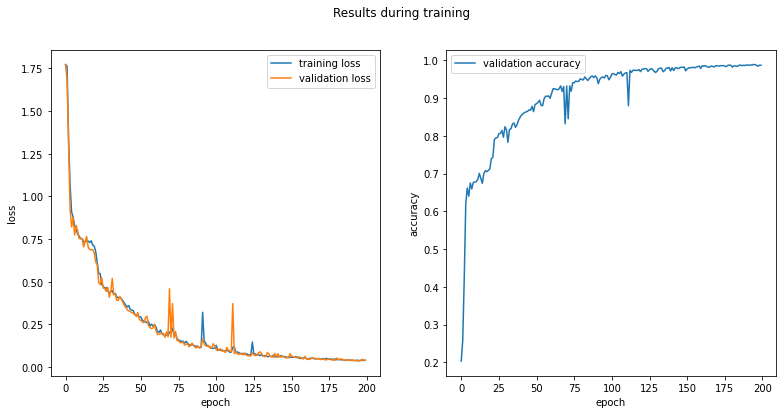

In [11]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.plot(trainer.tr_loss_log, label='training loss')
plt.plot(trainer.va_loss_log, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.plot(trainer.va_accu_log, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.suptitle('Results during training')
plt.show()

### Rebuild the best model to show the final results

First, we re-construct the model and get the estimation and true labels. 

In [12]:
final_model = CNNLSTMModel(n_input=N_FEATURE, n_hidden=N_HIDDEN, n_layer=N_LAYER, n_output=OUTPUT_SIZE, device=device)
final_model.to(device)
final_model.load_state_dict(trainer.best_parameter)
evaluator = Trainer(
    model=final_model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    tr_DataLoader=tr_dataloader,
    va_DataLoader=va_dataloader,
    epochs=EPOCH
)
_, acc, est, tar = evaluator.valid(print_info=False)
print(f'The accuracy on validation dataset is {acc*100:.2f}%')


The accuracy on validation dataset is 98.73%


Then we show the coressponding confusion matrix.

Populating the interactive namespace from numpy and matplotlib


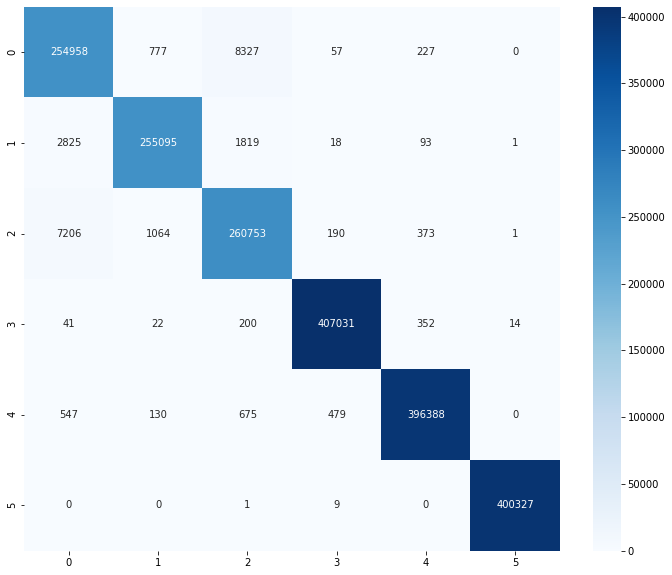

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
%pylab inline


_est = est.cpu().reshape(est.size(0)*est.size(1)).numpy()
_tar = tar.cpu().reshape(tar.size(0)*tar.size(1)).numpy()

cm = confusion_matrix(_tar, _est)
f, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

We can also randomly pick several samples to visualize the true results and estimated one.

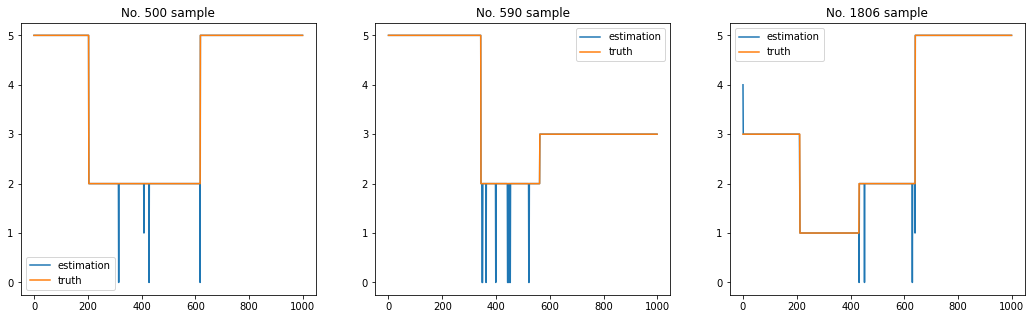

In [14]:
num_sample = 3

sample = np.random.randint(low=0, high=est.size(0), size=num_sample)
sample.sort()

plt.figure(figsize=(6*num_sample, 5))
for i in range(sample.shape[0]):
    plt.subplot(1, num_sample, i+1)
    plt.plot(est[sample[i]].cpu(), label='estimation')
    plt.plot(tar[sample[i]].cpu(), label='truth')
    plt.legend()
    plt.title('No. %d sample' % (sample[i]+1))
plt.show()